In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import eig
from collections import deque
from itertools import islice
from rich import print
from sklearn.cluster import KMeans


def build_graph_from_adjacency_matrix(adj_matrix):
    size = len(adj_matrix)
    G = nx.Graph()
    G.add_nodes_from(range(size))
    for i in range(size):
        for j in range(i + 1, size):
            if adj_matrix[i][j] != 0:
                G.add_edge(i, j, weight=adj_matrix[i][j])
    return G


def build_graph_from_edgelist(edge_list, weighted=False):
    G = nx.Graph()
    if weighted:
        for u, v, w in edge_list:
            G.add_edge(u, v, weight=w)
    else:
        for u, v in edge_list:
            G.add_edge(u, v)
    return G


def depth_first_search(G, start_node):
    visited = []
    stack = [start_node]
    visited_set = {start_node}

    while stack:
        node = stack.pop()
        visited.append(node)
        neighbors = list(G.neighbors(node))
        neighbors.reverse()
        for neighbor in neighbors:
            if neighbor not in visited_set:
                visited_set.add(neighbor)
                stack.append(neighbor)
    return visited


def breadth_first_search(G, start_node):
    visited = []
    queue = deque([start_node])
    visited_set = {start_node}

    while queue:
        node = queue.popleft()
        visited.append(node)
        for neighbor in G.neighbors(node):
            if neighbor not in visited_set:
                visited_set.add(neighbor)
                queue.append(neighbor)
    return visited


def shortest_path(G, source, target, weight=None):
    try:
        return nx.shortest_path(G, source=source, target=target, weight=weight)
    except Exception:
        return None


def all_paths_of_length(G, source, target, length):
    def dfs_paths(current_node, end_node, depth, path):
        if depth > length:
            return
        if current_node == end_node and depth == length:
            yield path
        for neighbor in G.neighbors(current_node):
            if neighbor not in path:
                yield from dfs_paths(neighbor, end_node, depth + 1, path + [neighbor])

    return list(dfs_paths(source, target, 0, [source]))


def detect_cycles(G):
    return nx.cycle_basis(G)


def degree_matrix(G):
    n = G.number_of_nodes()
    D = np.zeros((n, n))
    nodes = sorted(G.nodes())
    index_map = {node: idx for idx, node in enumerate(nodes)}
    for node in nodes:
        idx = index_map[node]
        D[idx, idx] = G.degree(node)
    return D


def local_overlap_measures(G):
    overlap_dict = {}
    for u, v in G.edges():
        neighbors_u = set(G.neighbors(u)) - {v}
        neighbors_v = set(G.neighbors(v)) - {u}
        common_neighbors = neighbors_u.intersection(neighbors_v)
        overlap_dict[(u, v)] = len(common_neighbors)
    return overlap_dict


def adjacency_eig(G):
    A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
    w, v = eig(A)
    return w, v


def laplacian_eig(G, normalized=False):
    if normalized:
        L = nx.normalized_laplacian_matrix(G, nodelist=sorted(G.nodes())).toarray()
    else:
        L = nx.laplacian_matrix(G, nodelist=sorted(G.nodes())).toarray()
    w, v = eig(L)
    return w, v


def laplacian_matrix(G, normalized=False):
    if normalized:
        return nx.normalized_laplacian_matrix(G, nodelist=sorted(G.nodes())).toarray()
    else:
        return nx.laplacian_matrix(G, nodelist=sorted(G.nodes())).toarray()


def spectral_clustering(G, k=2, normalized=True):
    if normalized:
        L = nx.normalized_laplacian_matrix(G, nodelist=sorted(G.nodes())).toarray()
    else:
        L = nx.laplacian_matrix(G, nodelist=sorted(G.nodes())).toarray()

    w, v = eig(L)
    idx = np.argsort(w)
    v_sorted = v[:, idx]
    X = v_sorted[:, :k]

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    return kmeans.labels_


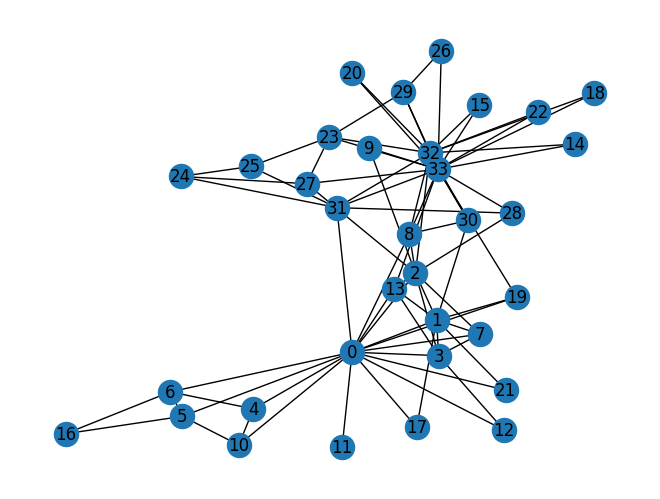

In [13]:
G = nx.karate_club_graph()

nx.draw(G, with_labels=True)
plt.show()

In [14]:
adj_matrix = nx.to_numpy_array(G)
edgelist = list(G.edges())

G1 = build_graph_from_adjacency_matrix(adj_matrix)
G2 = build_graph_from_edgelist(edgelist)

print(nx.is_isomorphic(G1, G2))

True

In [20]:
def analyze_graph(G, start_node=13, target_node=22, path_length=3):
    dfs_result = depth_first_search(G, start_node)
    bfs_result = breadth_first_search(G, start_node)
    sp_result = shortest_path(G, start_node, target_node)
    paths_length = all_paths_of_length(G, start_node, target_node, path_length)
    cycles = detect_cycles(G)

    print(f"DFS starting from node {start_node}: {dfs_result}")
    print(f"BFS starting from node {start_node}: {bfs_result}")

    if sp_result:
        print(f"Shortest path from {start_node} to {target_node}: {sp_result}")
    else:
        print(f"No path found from {start_node} to {target_node}")

    print(f"All paths of length {path_length} from {start_node} to {target_node}: {paths_length}")

    if cycles:
        print("Cycles detected:", cycles)
    else:
        print("No cycles detected.")

G = G1
analyze_graph(G)


DFS starting from node 13: [13, 0, 4, 5, 16, 6, 7, 8, 30, 32, 14, 15, 18, 20, 22, 23, 25, 24, 27, 29, 26, 10, 11, 
12, 17, 19, 21, 31, 28, 1, 2, 9, 3, 33]

BFS starting from node 13: [13, 0, 1, 2, 3, 33, 4, 5, 6, 7, 8, 10, 11, 12, 17, 19, 21, 31, 30, 9, 27, 28, 32, 14, 
15, 18, 20, 22, 23, 26, 29, 16, 24, 25]

Shortest path from 13 to 22: [13, 33, 22]

All paths of length 3 from 13 to 22: [[13, 2, 32, 22], [13, 33, 32, 22]]

Cycles detected:
[
    [8, 32, 33],
    [14, 32, 33],
    [15, 32, 33],
    [18, 32, 33],
    [20, 32, 33],
    [22, 32, 33],
    [23, 32, 33],
    [29, 32, 33],
    [30, 32, 33],
    [31, 32, 33],
    [8, 2, 32],
    [9, 2, 32, 33],
    [13, 2, 32, 33],
    [27, 2, 32, 33],
    [28, 2, 32, 33],
    [0, 7, 2],
    [1, 7, 2],
    [3, 7, 2],
    [0, 3, 2],
    [1, 3, 2],
    [13, 3, 2],
    [0, 12, 3],
    [0, 1, 2],
    [13, 1, 2],
    [19, 1, 2, 32, 33],
    [30, 1, 2, 32],
    [0, 21, 1],
    [0, 17, 1],
    [8, 0, 2],
    [13, 0, 2],
    [19, 0, 2, 32, 33],
    [31, 0, 2, 32],
    [4, 10, 0],
    [5, 10, 0],
    [4, 6, 0],
    [5, 6, 0],
    [5, 16, 6],
    [28, 31, 33],
    [23, 25, 31, 33],
    [24, 25, 31],
    [27, 24, 31, 33],
    [8, 30, 33],
    [23, 29, 33],
    [26, 29, 33],
    [23, 27, 33]
]

In [21]:
D = degree_matrix(G)
print("Degree matrix D:\n", D)

overlap = local_overlap_measures(G)
print("Local Overlap Measures:", overlap)

w_A, v_A = adjacency_eig(G)
print("Eigenvalues of A:", w_A)
print("Eigenvectors of A:\n", v_A)

w_L, v_L = laplacian_eig(G, normalized=False)
print("Eigenvalues of L (unnormalized):", w_L)

L_mat = laplacian_matrix(G, normalized=False)
print("Laplacian matrix:\n", L_mat)

Degree matrix D:
 [[16.  0.  0. ...  0.  0.  0.]
 [ 0.  9.  0. ...  0.  0.  0.]
 [ 0.  0. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  6.  0.  0.]
 [ 0.  0.  0. ...  0. 12.  0.]
 [ 0.  0.  0. ...  0.  0. 17.]]

Local Overlap Measures:
{
    (0, 1): 7,
    (0, 2): 5,
    (0, 3): 5,
    (0, 4): 2,
    (0, 5): 2,
    (0, 6): 2,
    (0, 7): 3,
    (0, 8): 1,
    (0, 10): 2,
    (0, 11): 0,
    (0, 12): 1,
    (0, 13): 3,
    (0, 17): 1,
    (0, 19): 1,
    (0, 21): 1,
    (0, 31): 0,
    (1, 2): 4,
    (1, 3): 4,
    (1, 7): 3,
    (1, 13): 3,
    (1, 17): 1,
    (1, 19): 1,
    (1, 21): 1,
    (1, 30): 0,
    (2, 3): 4,
    (2, 7): 3,
    (2, 8): 2,
    (2, 9): 0,
    (2, 13): 3,
    (2, 27): 0,
    (2, 28): 0,
    (2, 32): 1,
    (3, 7): 3,
    (3, 12): 1,
    (3, 13): 3,
    (4, 6): 1,
    (4, 10): 1,
    (5, 6): 2,
    (5, 10): 1,
    (5, 16): 1,
    (6, 16): 1,
    (8, 30): 2,
    (8, 32): 3,
    (8, 33): 2,
    (9, 33): 0,
    (13, 33): 0,
    (14, 32): 1,
    (14, 33): 1,
    (15, 32): 1,
    (15, 33): 1,
    (18, 32): 1,
    (18, 33): 1,
    (19, 33): 0,
    (20, 32): 1,
    (20, 33): 1,
    (22, 32): 1,
    (22, 33): 1,
    (23, 25): 0,
    (23, 27): 1,
    (23, 29): 2,
    (23, 32): 2,
    (23, 33): 3,
    (24, 25): 1,
    (24, 27): 0,
    (24, 31): 1,
    (25, 31): 1,
    (26, 29): 1,
    (26, 33): 1,
    (27, 33): 1,
    (28, 31): 1,
    (28, 33): 1,
    (29, 32): 2,
    (29, 33): 3,
    (30, 32): 2,
    (30, 33): 2,
    (31, 32): 1,
    (31, 33): 2,
    (32, 33): 10
}

Eigenvalues of A: [ 2.16875659e+01+0.00000000e+00j  1.71063201e+01+0.00000000e+00j
 -1.33449133e+01+0.00000000e+00j  9.64919417e+00+0.00000000e+00j
 -1.10396022e+01+0.00000000e+00j  7.82997687e+00+0.00000000e+00j
 -8.71566123e+00+0.00000000e+00j -7.79851507e+00+0.00000000e+00j
 -7.04557187e+00+0.00000000e+00j -6.66114004e+00+0.00000000e+00j
  4.63796702e+00+0.00000000e+00j -5.39013571e+00+0.00000000e+00j
 -4.60877622e+00+0.00000000e+00j -4.20706023e+00+0.00000000e+00j
  3.67239314e+00+0.00000000e+00j -2.56459972e+00+0.00000000e+00j
 -2.63046781e+00+0.00000000e+00j  3.00810189e+00+0.00000000e+00j
 -1.36223551e+00+0.00000000e+00j -1.15788606e+00+0.00000000e+00j
  2.60733871e+00+0.00000000e+00j  2.14145845e+00+0.00000000e+00j
  1.84325656e+00+0.00000000e+00j  1.19949546e+00+0.00000000e+00j
  8.79588769e-01+0.00000000e+00j  3.51432024e-01+0.00000000e+00j
 -8.75240463e-02+0.00000000e+00j -4.06397438e-16+0.00000000e+00j
 -4.95878051e-16+0.00000000e+00j  2.45320285e-16+5.44725586e-17j
  2.45320285e-16-5.44725586e-17j -8.61520091e-17+1.32319970e-16j
 -8.61520091e-17-1.32319970e-16j -1.36632403e-17+0.00000000e+00j]

Eigenvectors of A:
 [[ 3.12351228e-01+0.00000000e+00j  3.30913028e-01+0.00000000e+00j
  -1.79932521e-01+0.00000000e+00j ... -2.91102595e-18+3.34138323e-17j
  -2.91102595e-18-3.34138323e-17j  7.46476060e-18+0.00000000e+00j]
 [ 3.01751175e-01+0.00000000e+00j  3.34117975e-01+0.00000000e+00j
  -6.68022839e-02+0.00000000e+00j ... -2.63681744e-17-4.06854573e-17j
  -2.63681744e-17+4.06854573e-17j -7.24520241e-17+0.00000000e+00j]
 [ 3.60588620e-01+0.00000000e+00j  2.74594802e-01+0.00000000e+00j
   3.64308773e-02+0.00000000e+00j ...  2.99769317e-17-1.42843960e-17j
   2.99769317e-17+1.42843960e-17j  6.67652288e-17+0.00000000e+00j]
 ...
 [ 2.09456435e-01+0.00000000e+00j -2.00897511e-01+0.00000000e+00j
   4.52753944e-01+0.00000000e+00j ... -2.41920759e-17+2.43663879e-17j
  -2.41920759e-17-2.43663879e-17j -1.07835779e-16+0.00000000e+00j]
 [ 3.32261410e-01+0.00000000e+00j -3.32668610e-01+0.00000000e+00j
  -3.54241304e-01+0.00000000e+00j ... -7.13836911e-17+1.21361264e-17j
  -7.13836911e-17-1.21361264e-17j -9.02837665e-17+0.00000000e+00j]
 [ 3.64096882e-01+0.00000000e+00j -3.37914134e-01+0.00000000e+00j
  -3.94495696e-01+0.00000000e+00j ...  1.56682880e-17+2.76005383e-17j
   1.56682880e-17-2.76005383e-17j  2.65563260e-17+0.00000000e+00j]]

Eigenvalues of L (unnormalized): [5.20653410e+01 4.59907681e+01 4.18328632e+01 3.79927558e+01
 2.96883840e+01 2.55555039e+01 2.27849630e+01 2.13586504e+01
 1.93238240e+01 1.70337951e+01 1.48885752e+01 1.43813508e+01
 1.20754027e+01 1.18744202e+01 3.45489264e-15 1.02218147e+01
 1.00106981e+01 9.18096651e+00 1.18710730e+00 6.97788032e+00
 6.44605541e+00 5.59481244e+00 2.39431926e+00 5.16855490e+00
 4.97817925e+00 4.69727550e+00 4.54469763e+00 4.16160574e+00
 3.70606484e+00 3.80094429e+00 2.93182048e+00 2.96830180e+00
 3.12126310e+00 3.06104079e+00]

Laplacian matrix:
 [[42. -4. -5. ... -2.  0.  0.]
 [-4. 29. -6. ...  0.  0.  0.]
 [-5. -6. 33. ...  0. -2.  0.]
 ...
 [-2.  0.  0. ... 21. -4. -4.]
 [ 0.  0. -2. ... -4. 38. -5.]
 [ 0.  0.  0. ... -4. -5. 48.]]

Spectral Clustering labels: [0 0 0 0 2 2 2 0 1 1 2 0 0 0 1 1 2 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]

<ipython-input-22-df679934bae4>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab10', max(labels_list) + 1)


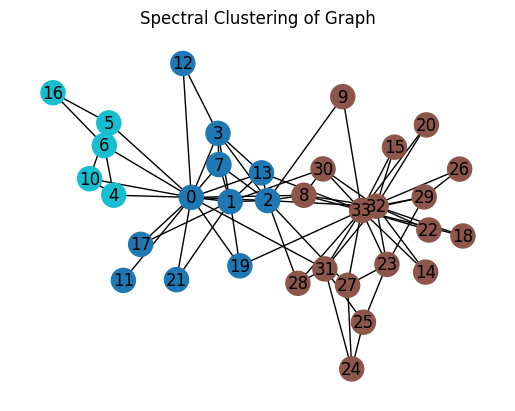

In [22]:
labels = spectral_clustering(G, k=3, normalized=True)
print("Spectral Clustering labels:", labels)

pos = nx.spring_layout(G)

labels_list = list(labels)

nx.draw_networkx(
    G,
    pos=pos,
    node_color=labels_list,
    with_labels=True,
    cmap=plt.cm.get_cmap('tab10', max(labels_list) + 1)
)

plt.title('Spectral Clustering of Graph')
plt.axis("off")
plt.show()